In [1]:
import os
import re
import scipy
from scipy import stats
import pickle
import subprocess
import shlex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
static_train_df = pd.read_excel('static_train_df.xlsx')
dynamic_train_df = pd.read_excel('dynamic_train_df.xlsx')
static_test_df = pd.read_excel('static_test_df.xlsx')
dynamic_test_df = pd.read_excel('dynamic_test_imputed_df.xlsx')
static_holdout_df = pd.read_excel('static_holdout_df.xlsx')
dynamic_holdout_df = pd.read_excel('dynamic_holdout_imputed_df.xlsx')

# notes_train_df = pd.read_excel('notes.csv')

In [7]:
from datetime import datetime

# # Assuming your date/time string is '11/6/2011 7:15'
# date_string = '10/10/28 15:54'

# # Convert the date/time string to a datetime object
# date_obj = datetime.strptime(date_string, '%m/%d/%y %H:%M')

# # Get the current time
# current_time = datetime.now()

# # Calculate the time difference
# time_difference = current_time - date_obj

# hours_difference = time_difference.total_seconds() / 3600

# # Print the time difference in seconds
# print("Time difference:", hours_difference)

In [8]:
def hours_difference(date_string):
    date_obj = datetime.strptime(date_string, '%m/%d/%y %H:%M')
    current_year = datetime.now().year
    if date_obj.year > current_year:
        date_obj = date_obj.replace(year=date_obj.year - 100)
    current_time = datetime.now()
    time_difference = current_time - date_obj
    hours_difference = time_difference.total_seconds() / 3600

    return hours_difference
    

In [9]:
hours_difference('3/25/78 21:55')

403345.5035211161

In [10]:
hours_difference('3/25/78 8:20')

403359.0875016744

In [11]:
hours_difference('3/25/78 13:45')

403353.67141693004

In [12]:
static_train_df['hosp_admittime_hour'] = static_train_df['hosp_admittime'].apply(lambda x: hours_difference(x))

In [13]:
static_train_df.head()

,id,hosp_admittime,hosp_dischtime,icu_intime,icu_outtime,los_icu,icu_death,gender,race,admission_age,weight_admit,height,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,icu_outcome,race_encode_African,race_encode_Asian,race_encode_Caucasian,race_encode_Hispanic,race_encode_Not Specified,race_encode_South American,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),hosp_admittime_hour
0,24099382,6/11/11 7:15,6/18/11 21:45,6/11/11 14:31,6/13/11 18:05,2.15,0,1,OTHER,58.441631,92.0,170.0,11,0,0,0,0,0,1,1,1,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,112216.173473
1,27824879,9/30/28 20:55,10/10/28 15:54,9/30/28 20:58,10/5/28 18:39,4.90,0,0,WHITE,79.748598,55.0,NaN,5,0,0,0,0,0,1,0,1,1,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,837098.506806
2,27146619,9/20/41 0:34,9/22/41 12:05,9/20/41 7:13,9/21/41 18:10,1.46,0,0,WHITE,81.717397,59.0,NaN,8,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,723406.856806
3,23169158,3/12/27 1:19,3/19/27 13:15,3/12/27 2:43,3/15/27 1:53,2.97,0,0,WHITE,84.191979,79.1,160.0,6,1,0,1,1,0,0,1,1,0,0,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,850750.106806
4,22717922,1/14/65 17:50,2/11/65 14:25,1/14/65 17:52,1/31/65 14:08,16.84,0,0,PORTUGUESE,58.039790,61.5,150.0,5,0,0,1,0,1,0,0,1,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,518981.590140


In [14]:
dynamic_train_df['charttime_hours'] = dynamic_train_df['charttime'].apply(lambda x: hours_difference(x))

# repeating for test and holdout set to employ the same pre-processing

dynamic_test_df['charttime_hours'] = dynamic_test_df['charttime'].apply(lambda x: hours_difference(x))
dynamic_holdout_df['charttime_hours'] = dynamic_holdout_df['charttime'].apply(lambda x: hours_difference(x))

In [15]:
dynamic_train_df.head()

,id,charttime,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,hematocrit,hemoglobin,mch,mchc,mcv,platelet,rbc,rdw,wbc,inr,pt,ptt,icu_outcome,charttime_hours
0,28793466,4/12/29 3:35,16,21.0,12,8.8,106,0.6,154.0,139,3.8,30.0,9.6,30.3,32.0,95.0,256,3.17,12.5,12.1,1.0,10.9,27.8,4,832459.851204
1,25611175,11/29/40 3:50,15,27.0,28,8.5,101,1.7,223.0,139,3.5,28.0,9.1,30.3,32.5,93.0,216,3.00,13.8,6.4,1.3,14.9,33.3,3,730483.601204
2,26115624,9/7/50 0:22,12,22.0,9,7.9,111,0.6,97.0,141,3.6,26.4,9.6,31.3,36.5,86.0,115,3.07,15.4,0.8,1.2,13.9,25.8,2,644831.067870
3,28164589,3/11/59 1:11,12,34.0,58,8.3,103,2.1,89.0,146,3.4,30.4,8.9,30.7,29.3,105.0,105,2.90,20.0,4.8,3.8,41.7,40.2,2,570262.251204
4,26115624,9/1/50 20:14,14,24.0,11,7.8,103,1.2,124.0,138,3.3,29.9,9.7,30.0,32.7,91.0,186,3.29,15.4,9.6,1.3,14.3,32.2,2,644955.201204


In [16]:
dynamic_train_df.id.nunique()

14289

In [61]:
# getting the first and last dynamic measurement from each patient id

def get_last_measurement_index(group):
    last_measurement = group['charttime_hours'].min()
    last_measurement_index = group[group['charttime_hours'] == last_measurement].index[-1]
    return last_measurement_index

def get_first_measurement_index(group):
    first_measurement = group['charttime_hours'].max()
    first_measurement_index = group[group['charttime_hours'] == first_measurement].index[-1]
    return first_measurement_index

last_measurement_train_indices = dynamic_train_df.groupby('id').apply(get_last_measurement_index)
first_measurement_train_indices = dynamic_train_df.groupby('id').apply(get_first_measurement_index)

last_measurement_test_indices = dynamic_test_df.groupby('id').apply(get_last_measurement_index)
first_measurement_test_indices = dynamic_test_df.groupby('id').apply(get_first_measurement_index)

last_measurement_holdout_indices = dynamic_holdout_df.groupby('id').apply(get_last_measurement_index)
first_measurement_holdout_indices = dynamic_holdout_df.groupby('id').apply(get_first_measurement_index)

last_measurement_train_indices_list = last_measurement_train_indices.tolist()
first_measurement_train_indices_list = first_measurement_train_indices.tolist()


In [62]:
print(last_measurement_indices_list)
print(first_measurement_indices_list)

[8267, 59907, 61551, 15648, 33984, 978, 63763, 10307, 44561, 7167, 10675, 31436, 35877, 48700, 45690, 4623, 40582, 28587, 38973, 18183, 21662, 12427, 5919, 14850, 46494, 11128, 46527, 12404, 15285, 60953, 40358, 62430, 55874, 21968, 25546, 61782, 37457, 54559, 38233, 40812, 31313, 46526, 45813, 25223, 31318, 29113, 49213, 14626, 46246, 42873, 32119, 9715, 63690, 11389, 40773, 23248, 47006, 49333, 42717, 10735, 38476, 12445, 31473, 31030, 55303, 18794, 39052, 42078, 48640, 49370, 8666, 57972, 49387, 58073, 53749, 60426, 59475, 28092, 40697, 63142, 11082, 44280, 39302, 22136, 68, 62431, 20744, 52517, 10945, 24586, 27568, 38353, 64585, 23801, 8599, 20867, 22167, 25008, 60410, 45004, 28942, 55509, 38946, 34879, 53554, 27004, 15647, 35736, 59801, 41715, 27659, 3300, 24360, 35179, 29913, 25106, 56773, 54681, 46073, 940, 64917, 21890, 57007, 7422, 20409, 58270, 57387, 918, 21435, 30699, 28036, 35808, 43027, 9867, 27150, 33718, 49688, 14023, 29470, 64012, 17693, 38562, 1446, 36352, 28441, 5822

In [63]:
set_last = set(last_measurement_indices_list)
set_first = set(first_measurement_indices_list)
index_with_1_measurement = set_last.intersection(set_first)

print(index_with_1_measurement)
print(len(index_with_1_measurement))

{1, 8, 9, 8206, 16399, 24592, 32787, 16406, 32, 33, 49193, 32811, 46, 49198, 24633, 57402, 57406, 32837, 70, 24647, 32841, 32842, 57433, 41052, 32865, 8292, 8303, 24690, 116, 57468, 16528, 8345, 24737, 49317, 41127, 57514, 32942, 57519, 57522, 49331, 49338, 8383, 41154, 24770, 41156, 57539, 24776, 57555, 41178, 49370, 227, 230, 16614, 57575, 33001, 49386, 41197, 49390, 57595, 57602, 57603, 41221, 16660, 57620, 24855, 24862, 49447, 57642, 309, 41271, 49463, 8520, 49490, 8531, 41312, 49505, 24933, 364, 41328, 41331, 24951, 49528, 49531, 49538, 33159, 33160, 8584, 33162, 49545, 8590, 57745, 33171, 41365, 57749, 57751, 49561, 16798, 33183, 49568, 24993, 16804, 8613, 16825, 49594, 41404, 57789, 41409, 33219, 49613, 41433, 49630, 57825, 33250, 8677, 16871, 41449, 16878, 57839, 41460, 49652, 41464, 8696, 25080, 49661, 8711, 49676, 8728, 49688, 25122, 16937, 49705, 41515, 25131, 25141, 572, 25153, 49731, 57924, 33349, 8776, 8778, 33358, 33364, 33365, 16985, 25181, 612, 57956, 33403, 41595, 334

In [64]:
dynamic_train_df.iloc[8206]

id                      25009110
charttime            4/5/42 1:47
aniongap                       8
bicarbonate                 37.0
bun                           15
calcium                      9.1
chloride                      95
creatinine                   0.6
glucose                    181.0
sodium                       137
potassium                    3.4
hematocrit                  37.5
hemoglobin                  11.8
mch                         30.2
mchc                        31.4
mcv                         96.0
platelet                     307
rbc                         3.91
rdw                         18.8
wbc                          8.7
inr                          1.4
pt                          15.5
ptt                         34.6
icu_outcome                    4
charttime_hours    718675.179775
Name: 8206, dtype: object

In [65]:
dynamic_train_df_last = dynamic_train_df.iloc[last_measurement_indices_list]
print(dynamic_train_df_last.id.nunique())

dynamic_train_df_first = dynamic_train_df.iloc[first_measurement_indices_list]
print(dynamic_train_df_first.id.nunique())



14289
14289


In [66]:
for column in dynamic_train_df_last.columns:
    print(column)

id
charttime
aniongap
bicarbonate
bun
calcium
chloride
creatinine
glucose
sodium
potassium
hematocrit
hemoglobin
mch
mchc
mcv
platelet
rbc
rdw
wbc
inr
pt
ptt
icu_outcome
charttime_hours


In [67]:
# change_df = pd.DataFrame()

# change_df['calcium_delta'] = dynamic_train_df_last['calcium'] - dynamic_train_df_first['calcium']
# change_df.head()

In [68]:
# Merge the two DataFrames based on the ID column
merged_dynamic_df = pd.merge(dynamic_train_df_last, dynamic_train_df_first, on='id', suffixes=('_last', '_first'))

# merged_dynamic_df.info()

change_df = merged_dynamic_df.copy()


for column in dynamic_train_df_last.columns:
    if column != 'id' and column != 'charttime':
        change_df[column + '_delta'] = merged_dynamic_df[column + '_last'] - merged_dynamic_df[column + '_first']
        # change_df.drop(column + '_first')

# Droping the measurement from the first reading
change_df.drop(columns=[column + '_first' for column in dynamic_train_df_first.columns if column not in ['id', 'charttime']], inplace=True)


In [69]:
print(change_df.columns.nunique())
change_df.head()

49


,id,charttime_last,aniongap_last,bicarbonate_last,bun_last,calcium_last,chloride_last,creatinine_last,glucose_last,sodium_last,potassium_last,hematocrit_last,hemoglobin_last,mch_last,mchc_last,mcv_last,platelet_last,rbc_last,rdw_last,wbc_last,inr_last,pt_last,ptt_last,icu_outcome_last,charttime_hours_last,charttime_first,aniongap_delta,bicarbonate_delta,bun_delta,calcium_delta,chloride_delta,creatinine_delta,glucose_delta,sodium_delta,potassium_delta,hematocrit_delta,hemoglobin_delta,mch_delta,mchc_delta,mcv_delta,platelet_delta,rbc_delta,rdw_delta,wbc_delta,inr_delta,pt_delta,ptt_delta,icu_outcome_delta,charttime_hours_delta
0,20001305,3/25/78 21:55,13,24.0,50,10.8,108,0.9,131.0,141,4.1,29.5,9.5,30.6,32.5,94.0,169,3.12,16.5,11.1,1.3,14.1,33.1,6,403343.046442,3/25/78 8:20,-2,1.0,3,-0.6,0,0.1,-23.0,-1,-0.2,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,-0.3,-3.9,-5.4,0,-13.583349
1,20001361,5/5/43 15:02,18,23.0,40,7.9,107,3.7,123.0,144,3.8,29.8,9.8,30.1,32.7,91.0,176,3.29,15.7,10.2,1.6,17.7,30.0,4,709181.929877,5/4/43 17:24,4,1.0,12,1.6,0,1.2,-38.0,7,-2.0,-4.1,-1.8,-0.6,-1.4,1.0,-40,-0.47,2.6,-10.6,-0.2,-1.7,-3.5,0,-21.633305
2,20002506,3/20/32 1:01,14,22.0,9,8.8,108,0.7,94.0,144,4.0,37.8,12.6,30.1,33.3,90.0,175,4.18,12.0,8.3,1.2,13.2,30.9,4,806707.946548,3/19/32 6:13,-2,0.0,-4,-0.5,7,0.0,-6.0,5,-0.1,-2.2,-1.2,0.0,-1.2,3.0,-48,-0.40,0.2,-2.4,0.0,0.6,2.2,0,-18.799960
3,20003425,7/23/55 2:19,11,21.0,23,8.5,101,0.8,162.0,133,5.0,24.4,7.6,28.0,31.1,90.0,211,2.71,15.7,10.0,1.3,14.9,33.3,3,602106.646456,7/21/55 23:27,3,-8.0,-3,-0.9,4,0.0,45.0,-1,0.0,-4.2,-1.3,-0.2,0.0,-1.0,-23,-0.45,0.2,4.4,-0.1,0.2,-2.3,0,-26.866738
4,20003491,12/19/97 5:00,16,20.0,47,7.4,97,1.9,110.0,133,6.4,36.1,11.8,29.7,32.7,91.0,145,3.97,15.9,6.0,1.8,19.5,42.5,2,230343.963159,12/17/97 15:33,1,-1.0,20,-1.4,-6,0.6,-92.0,-6,0.4,-0.9,-0.3,0.0,0.0,0.0,-25,-0.10,-0.2,0.3,0.5,5.2,10.3,0,-37.450018


In [70]:
print(static_train_df.columns.nunique())
static_train_df.head()

48


,id,hosp_admittime,hosp_dischtime,icu_intime,icu_outtime,los_icu,icu_death,gender,race,admission_age,weight_admit,height,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,icu_outcome,race_encode_African,race_encode_Asian,race_encode_Caucasian,race_encode_Hispanic,race_encode_Not Specified,race_encode_South American,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),hosp_admittime_hour
0,24099382,6/11/11 7:15,6/18/11 21:45,6/11/11 14:31,6/13/11 18:05,2.15,0,1,OTHER,58.441631,92.0,170.0,11,0,0,0,0,0,1,1,1,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,112213.712836
1,27824879,9/30/28 20:55,10/10/28 15:54,9/30/28 20:58,10/5/28 18:39,4.90,0,0,WHITE,79.748598,55.0,NaN,5,0,0,0,0,0,1,0,1,1,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,837096.046169
2,27146619,9/20/41 0:34,9/22/41 12:05,9/20/41 7:13,9/21/41 18:10,1.46,0,0,WHITE,81.717397,59.0,NaN,8,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,723404.396169
3,23169158,3/12/27 1:19,3/19/27 13:15,3/12/27 2:43,3/15/27 1:53,2.97,0,0,WHITE,84.191979,79.1,160.0,6,1,0,1,1,0,0,1,1,0,0,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,850747.646169
4,22717922,1/14/65 17:50,2/11/65 14:25,1/14/65 17:52,1/31/65 14:08,16.84,0,0,PORTUGUESE,58.039790,61.5,150.0,5,0,0,1,0,1,0,0,1,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,518979.129502


In [71]:
static_train_df_dropped = static_train_df.drop(columns=['hosp_admittime',
                                                'hosp_dischtime',
                                                'icu_intime',
                                                'icu_outtime',
                                                'race',
                                                'hosp_admittime_hour',
                                                'height',
                                                'weight_admit',
                                                'icu_outcome'
                                               ])
print(static_train_df_dropped.columns.nunique())


dynamic_train_df_dropped = change_df.drop(columns=['charttime_last',
                                                          'icu_outcome_last',
                                                          'charttime_hours_last',
                                                          'charttime_first',
                                                          'icu_outcome_delta',
                                                          'charttime_hours_delta'
                                                         ])
print(dynamic_train_df_dropped.columns.nunique())
                                                          

39
43


In [72]:
train_combined_df = pd.merge(static_train_df_dropped, dynamic_train_df_dropped, on='id', how='left')

In [73]:
train_combined_df.head()

,id,los_icu,icu_death,gender,admission_age,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,race_encode_African,race_encode_Asian,race_encode_Caucasian,race_encode_Hispanic,race_encode_Not Specified,race_encode_South American,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),aniongap_last,bicarbonate_last,bun_last,calcium_last,chloride_last,creatinine_last,glucose_last,sodium_last,potassium_last,hematocrit_last,hemoglobin_last,mch_last,mchc_last,mcv_last,platelet_last,rbc_last,rdw_last,wbc_last,inr_last,pt_last,ptt_last,aniongap_delta,bicarbonate_delta,bun_delta,calcium_delta,chloride_delta,creatinine_delta,glucose_delta,sodium_delta,potassium_delta,hematocrit_delta,hemoglobin_delta,mch_delta,mchc_delta,mcv_delta,platelet_delta,rbc_delta,rdw_delta,wbc_delta,inr_delta,pt_delta,ptt_delta
0,24099382,2.15,0,1,58.441631,11,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,26.0,14,8.7,106,0.8,102.0,141,4.1,35.5,11.3,31.7,31.9,99.0,286,3.57,16.6,12.0,1.3,14.3,32.2,-1,2.0,0,0.6,-1,-0.1,-61.0,0,-0.3,-0.5,1.6,1.7,-0.8,8.0,100,0.28,1.2,2.4,0.0,0.0,0.0
1,27824879,4.90,0,0,79.748598,5,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,15,22.0,17,7.9,103,0.7,155.0,136,3.9,41.8,14.2,31.7,34.1,93.0,248,4.49,15.1,27.3,1.1,11.6,27.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0
2,27146619,1.46,0,0,81.717397,8,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,16,19.0,60,7.7,113,2.3,97.0,143,5.1,30.9,10.1,30.3,32.5,93.0,153,3.32,13.3,9.3,1.5,15.7,27.2,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0
3,23169158,2.97,0,0,84.191979,6,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,17,12.0,44,10.1,112,2.2,96.0,136,4.7,27.9,8.4,26.9,30.1,89.0,157,3.12,17.6,8.8,1.2,13.4,32.6,2,-3.0,-2,-0.8,5,-0.3,-57.0,4,-0.1,-6.0,-1.7,-0.3,0.3,-2.0,-38,-0.59,0.2,-4.1,0.1,1.4,4.5
4,22717922,16.84,0,0,58.039790,5,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,15,23.0,27,8.4,90,1.3,143.0,128,3.4,21.1,6.9,30.0,32.7,92.0,48,2.30,20.9,7.6,1.7,18.6,84.0,-2,2.0,-1,0.2,0,-0.1,11.0,0,-0.2,-0.6,-0.1,0.3,0.4,0.0,26,-0.06,-0.2,0.4,-0.3,-2.7,-66.0


In [74]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [75]:
X_train = train_combined_df.drop(columns=['id',
                                          'los_icu',
                                          'icu_death'
                                         ])
y_train = train_combined_df.los_icu
                                          

In [76]:
print(X_train.columns.nunique())
X_train.head()

78


,gender,admission_age,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,race_encode_African,race_encode_Asian,race_encode_Caucasian,race_encode_Hispanic,race_encode_Not Specified,race_encode_South American,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),aniongap_last,bicarbonate_last,bun_last,calcium_last,chloride_last,creatinine_last,glucose_last,sodium_last,potassium_last,hematocrit_last,hemoglobin_last,mch_last,mchc_last,mcv_last,platelet_last,rbc_last,rdw_last,wbc_last,inr_last,pt_last,ptt_last,aniongap_delta,bicarbonate_delta,bun_delta,calcium_delta,chloride_delta,creatinine_delta,glucose_delta,sodium_delta,potassium_delta,hematocrit_delta,hemoglobin_delta,mch_delta,mchc_delta,mcv_delta,platelet_delta,rbc_delta,rdw_delta,wbc_delta,inr_delta,pt_delta,ptt_delta
0,1,58.441631,11,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,26.0,14,8.7,106,0.8,102.0,141,4.1,35.5,11.3,31.7,31.9,99.0,286,3.57,16.6,12.0,1.3,14.3,32.2,-1,2.0,0,0.6,-1,-0.1,-61.0,0,-0.3,-0.5,1.6,1.7,-0.8,8.0,100,0.28,1.2,2.4,0.0,0.0,0.0
1,0,79.748598,5,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,15,22.0,17,7.9,103,0.7,155.0,136,3.9,41.8,14.2,31.7,34.1,93.0,248,4.49,15.1,27.3,1.1,11.6,27.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0
2,0,81.717397,8,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,16,19.0,60,7.7,113,2.3,97.0,143,5.1,30.9,10.1,30.3,32.5,93.0,153,3.32,13.3,9.3,1.5,15.7,27.2,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0
3,0,84.191979,6,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,17,12.0,44,10.1,112,2.2,96.0,136,4.7,27.9,8.4,26.9,30.1,89.0,157,3.12,17.6,8.8,1.2,13.4,32.6,2,-3.0,-2,-0.8,5,-0.3,-57.0,4,-0.1,-6.0,-1.7,-0.3,0.3,-2.0,-38,-0.59,0.2,-4.1,0.1,1.4,4.5
4,0,58.039790,5,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,15,23.0,27,8.4,90,1.3,143.0,128,3.4,21.1,6.9,30.0,32.7,92.0,48,2.30,20.9,7.6,1.7,18.6,84.0,-2,2.0,-1,0.2,0,-0.1,11.0,0,-0.2,-0.6,-0.1,0.3,0.4,0.0,26,-0.06,-0.2,0.4,-0.3,-2.7,-66.0


In [81]:
# Scaling the input values of X_train

from sklearn.preprocessing import StandardScaler

# scaler = 
# X_train_scaled = scaler.fit_transform(X_train)

num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

In [84]:
X_train.head()

,gender,admission_age,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke,race_encode_African,race_encode_Asian,race_encode_Caucasian,race_encode_Hispanic,race_encode_Not Specified,race_encode_South American,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),aniongap_last,bicarbonate_last,bun_last,calcium_last,chloride_last,creatinine_last,glucose_last,sodium_last,potassium_last,hematocrit_last,hemoglobin_last,mch_last,mchc_last,mcv_last,platelet_last,rbc_last,rdw_last,wbc_last,inr_last,pt_last,ptt_last,aniongap_delta,bicarbonate_delta,bun_delta,calcium_delta,chloride_delta,creatinine_delta,glucose_delta,sodium_delta,potassium_delta,hematocrit_delta,hemoglobin_delta,mch_delta,mchc_delta,mcv_delta,platelet_delta,rbc_delta,rdw_delta,wbc_delta,inr_delta,pt_delta,ptt_delta
0,0.881235,-0.563436,1.774812,-0.604490,-0.385171,-0.724663,-0.861473,-0.356470,1.588920,1.412212,0.623726,-0.944235,-0.374677,-0.388041,-0.164393,-1.400080,-0.197225,2.453196,-0.026464,-0.211895,-0.011832,6.041849,-0.027756,-1.127697,-0.369925,-0.273432,-0.468075,-0.363662,-0.37078,-0.600822,-0.489721,-0.083527,-0.054295,-0.148916,-0.421541,2.692582,-0.442503,0.569159,-0.788330,0.512401,0.404259,-0.576686,-0.624023,0.557843,-0.232722,0.965554,0.753236,0.748340,-0.558205,1.205214,0.965171,0.336173,0.387229,0.044828,-0.275237,-0.285629,-0.263294,-0.046586,0.549469,-0.029558,0.896869,-0.404420,-0.103348,-0.540744,-0.023671,-0.299021,0.311088,1.313026,0.981505,-0.750927,1.781350,1.524201,0.842213,0.702134,0.333205,0.045301,0.044796,-0.005687
1,-1.134771,0.802145,-0.277074,-0.604490,-0.385171,-0.724663,-0.861473,-0.356470,1.588920,-0.708109,0.623726,1.059058,-0.374677,-0.388041,-0.164393,0.714245,-0.197225,-0.407631,-0.026464,-0.211895,-0.011832,-0.165512,-0.027756,0.886763,-0.369925,-0.273432,-0.468075,-0.363662,-0.37078,-0.600822,-0.489721,-0.083527,-0.054295,-0.148916,-0.421541,2.692582,0.030451,-0.243401,-0.662871,-0.545036,-0.056078,-0.629043,0.290440,-0.424947,-0.548295,2.183639,2.426371,0.748340,0.918719,0.267948,0.575047,1.854896,-0.320107,1.865693,-0.562511,-0.663368,-0.585772,0.203570,0.031231,-0.029558,0.139617,-0.194505,0.000655,0.145714,-0.023671,0.081035,0.410618,0.362163,-0.020282,-0.123226,0.089756,0.248590,0.357890,-0.097202,0.016572,0.045301,0.044796,-0.005687
2,-1.134771,0.928327,0.748869,-0.604490,-0.385171,1.379952,1.160802,-0.356470,-0.629358,-0.708109,-1.603267,1.059058,-0.374677,-0.388041,-0.164393,0.714245,-0.197225,-0.407631,-0.026464,-0.211895,-0.011832,-0.165512,-0.027756,0.886763,-0.369925,-0.273432,-0.468075,-0.363662,-0.37078,-0.600822,2.041980,-0.083527,-0.054295,-0.148916,-0.421541,-0.371391,0.266928,-0.852821,1.135372,-0.809396,1.478377,0.208665,-0.710293,0.950959,1.345148,0.076159,0.060904,0.158108,-0.155408,0.267948,-0.400265,-0.076524,-1.168911,-0.276501,0.012038,-0.089765,-0.573369,0.203570,0.031231,-0.029558,0.139617,-0.194505,0.000655,0.145714,-0.023671,0.081035,0.410618,0.362163,-0.020282,-0.123226,0.089756,0.248590,0.357890,-0.097202,0.016572,0.045301,0.044796,-0.005687
3,-1.134771,1.086925,0.064907,1.654286,-0.385171,1.379952,1.160802,-0.356470,-0.629358,1.412212,0.623726,-0.944235,-0.374677,-0.388041,-0.164393,0.714245,-0.197225,-0.407631,-0.026464,-0.211895,-0.011832,-0.165512,-0.027756,-1.127697,2.703250,-0.273432,-0.468075,-0.363662,-0.37078,-0.600822,2.041980,-0.08352

In [85]:
# Training with L1 lasso regularization

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

coefficients = lasso_model.coef_

print("Coefficients:", coefficients)

Coefficients: [ 0.04343448 -0.20796475 -0.          0.13972126 -0.0770002   0.
 -0.         -0.01124079  0.06962622 -0.         -0.04783114 -0.12931238
  0.08471264  0.          0.         -0.         -0.          0.0972811
 -0.         -0.         -0.         -0.00851016 -0.          0.
 -0.          0.          0.43658789  0.         -0.01117926 -0.
 -0.01508461  0.         -0.          0.28717789  0.15194009  0.17045485
  0.08784719 -0.09061157  0.1695007  -0.16245354  0.         -0.
  0.01604807  0.05830957  0.          0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.11235859
  0.          0.09602236  0.2218888   0.         -0.          0.
  0.06299397  0.          0.11158792 -0.          0.          0.
 -0.0787915  -0.          0.          0.07061978 -0.05338781 -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]


In [86]:
feature_list = X_train.columns.tolist()

coefficients_df = pd.DataFrame({'Feature': feature_list, 'Coefficient': coefficients})

print(coefficients_df)

                                              Feature  Coefficient
0                                              gender     0.043434
1                                       admission_age    -0.207965
2                                      charlson_score    -0.000000
3                                 atrial_fibrillation     0.139721
4                                    malignant_cancer    -0.077000
5                                                 chf     0.000000
6                                                 ckd    -0.000000
7                                                 cld    -0.011241
8                                                copd     0.069626
9                                            diabetes    -0.000000
10                                       hypertension    -0.047831
11                                                ihd    -0.129312
12                                             stroke     0.084713
13                                race_encode_African     0.00

In [87]:
Lasso_pred_los = lasso_model.predict(X_train)
train_combined_df['Lasso_pred_los'] = lasso_model.predict(X_train)

In [88]:
train_combined_df.head()

Columns_compare = ['id', 'los_icu', 'Lasso_pred_los']
compare_df = train_combined_df[Columns_compare]

In [89]:
compare_df.head(10)

,id,los_icu,Lasso_pred_los
0,24099382,2.15,4.990797
1,27824879,4.90,4.587768
2,27146619,1.46,4.258187
3,23169158,2.97,4.205290
4,22717922,16.84,6.061919
5,29179088,3.83,3.801302
6,27139242,2.39,4.403209
7,20778724,1.51,4.040664
8,21999692,3.05,7.426702
9,22653066,2.47,4.067997


In [90]:
mse_lasso = mean_squared_error(y_train, Lasso_pred_los)
print("Lasso Regression MSE:", mse_lasso)

Lasso Regression MSE: 35.17067094027021


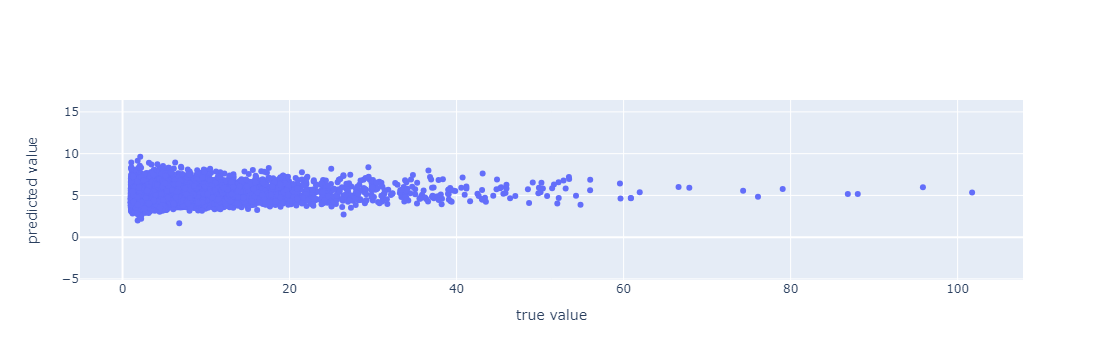

In [91]:
fig = go.Figure(
    data=go.Scatter(
        x=y_train.squeeze(),
        y=Lasso_pred_los.squeeze(),
        mode='markers'
    )
)
fig.update_xaxes(
    title='true value'
  )
fig.update_yaxes(
    title='predicted value',
    scaleanchor='x',
    scaleratio=1
  )

In [92]:
import torch
import torch.nn as nn
from torch.optim import SGD #gradient descent optimizer

# NumPy for math operations, and Pandas for processing tabular data.
import numpy as np
import pandas as pd

# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

In [93]:
y_train.head()

0     2.15
1     4.90
2     1.46
3     2.97
4    16.84
Name: los_icu, dtype: float64

In [94]:
X_train_tensor = torch.tensor(X_train.to_numpy(),dtype=torch.float32)
m,n = X_train_tensor.shape
y_train_tensor = torch.tensor(y_train.to_numpy(),dtype=torch.float32).reshape(m,1)

In [95]:
# h = torch.nn.Linear(
#     in_features=78,
#     out_features=1,
#     bias=True
# )

# print(h.weight)
# print(h.bias)

print('Training input has size: ',X_train_tensor.shape)
print('y_Training input has size: ',y_train_tensor.shape)

Training input has size:  torch.Size([14289, 78])
y_Training input has size:  torch.Size([14289, 1])


In [98]:
h = torch.nn.Linear(
    in_features=78,
    out_features=1,
    bias=True
)

# For torch SGD, we need to tell it which parameter we what to optimize.
GD_optimizer = torch.optim.SGD(lr=0.05, params=h.parameters())
J_MSE = torch.nn.MSELoss()

# Apply gradient descent 10000 times
nIter = 10000
printInterval = 500

# PyTorch optimization steps:
# 1. Clear gradient
# 2. Calculate model and loss values (so-called forward path)
# 3. Calculate gradient of loss (so-called backward path)
# 4. Ask optimizer to update parameters of model
for i in range(nIter):
    # Step 1
    GD_optimizer.zero_grad()
    # Step 2
    pred = h(X_train_tensor)
    loss = J_MSE(pred,y_train_tensor)
    # Step 3
    loss.backward()
    # Step 4
    GD_optimizer.step()
    # Print loss value to track optimization progress
    if i == 0 or ((i+1) % printInterval) == 0:
        # We take square root of MSE (PyTorch internally averaged in J_MSE)
        # so that scale of printout is same as scale of y values.
        print('Iter {} : average rooted training MSE {:.3f}'.format(i+1,torch.sqrt(loss).item()))

Iter 1 : average rooted training MSE 7.763
Iter 500 : average rooted training MSE 5.889
Iter 1000 : average rooted training MSE 5.887
Iter 1500 : average rooted training MSE 5.886
Iter 2000 : average rooted training MSE 5.886
Iter 2500 : average rooted training MSE 5.886
Iter 3000 : average rooted training MSE 5.886
Iter 3500 : average rooted training MSE 5.886
Iter 4000 : average rooted training MSE 5.886
Iter 4500 : average rooted training MSE 5.886
Iter 5000 : average rooted training MSE 5.886
Iter 5500 : average rooted training MSE 5.886
Iter 6000 : average rooted training MSE 5.886
Iter 6500 : average rooted training MSE 5.886
Iter 7000 : average rooted training MSE 5.886
Iter 7500 : average rooted training MSE 5.886
Iter 8000 : average rooted training MSE 5.886
Iter 8500 : average rooted training MSE 5.886
Iter 9000 : average rooted training MSE 5.886
Iter 9500 : average rooted training MSE 5.886
Iter 10000 : average rooted training MSE 5.886


In [99]:
# Training with L2 ridge regularization

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

ridge_coef = ridge_model.coef_

print("Coefficients:", ridge_coef)

Coefficients: [ 0.14662862 -0.36100075  0.0260712   0.24120261 -0.16760507  0.03580377
 -0.0648681  -0.16612472  0.18975569 -0.05933665 -0.11027953 -0.2175575
  0.17656174  0.02718073  0.02195493 -0.06643279 -0.05663324  0.08768984
 -0.04391939 -0.06006914 -0.04152924 -0.14380772 -0.09422108 -0.08782694
 -0.171403   -0.05408682  0.39480268  0.00843547 -0.20157809 -0.14453689
 -0.16830251  0.05579046 -0.04178972  0.36179824  0.19487743  0.20974651
  0.19766187 -0.02788964  0.38700249 -0.35957169 -0.00700157 -0.21371948
  0.09890191  0.12724516  0.05800976  0.66632745  0.98816838  1.15853045
 -0.86609076 -1.63140261 -0.04302309 -1.58263561  0.19477202  0.18965684
 -0.12876731  0.28459768  0.39549492 -0.18300048 -0.24517462 -0.05690995
  0.25491276 -0.13423891  0.23850563 -0.01067875  0.15380676 -0.01288518
 -0.69871973  0.98069801  0.78502773 -0.64862259 -0.96997941 -0.0373256
 -0.45407088 -0.0652778   0.00743726 -0.12720304  0.10795034 -0.18029225]


In [100]:
feature_list = X_train.columns.tolist()

ridge_coefficients_df = pd.DataFrame({'Feature': feature_list, 'Coefficient': ridge_coef})

print(ridge_coefficients_df)

                                              Feature  Coefficient
0                                              gender     0.146629
1                                       admission_age    -0.361001
2                                      charlson_score     0.026071
3                                 atrial_fibrillation     0.241203
4                                    malignant_cancer    -0.167605
5                                                 chf     0.035804
6                                                 ckd    -0.064868
7                                                 cld    -0.166125
8                                                copd     0.189756
9                                            diabetes    -0.059337
10                                       hypertension    -0.110280
11                                                ihd    -0.217557
12                                             stroke     0.176562
13                                race_encode_African     0.02

In [101]:
ridge_pred_los = ridge_model.predict(X_train)
train_combined_df['ridge_pred_los'] = ridge_model.predict(X_train)

In [102]:
mse_ridge = mean_squared_error(y_train, ridge_pred_los)
print("Ridge Regression MSE:", mse_ridge)

Ridge Regression MSE: 34.63922286021653


In [103]:
Columns_compare = ['id', 'los_icu', 'ridge_pred_los']
compare_df = train_combined_df[Columns_compare]

In [104]:
compare_df.head(10)

,id,los_icu,ridge_pred_los
0,24099382,2.15,5.562725
1,27824879,4.90,5.214261
2,27146619,1.46,3.872419
3,23169158,2.97,3.139619
4,22717922,16.84,6.597938
5,29179088,3.83,3.176405
6,27139242,2.39,4.293527
7,20778724,1.51,3.708106
8,21999692,3.05,9.819334
9,22653066,2.47,4.459045


In [105]:
# base regression without regularization

from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [106]:
lin_pred_los = linear.predict(X_train)
mse_linear = mean_squared_error(y_train, lin_pred_los)
print("Linear Regression MSE:", mse_linear)


Linear Regression MSE: 34.6803613886604


In [107]:
linear_coef = linear.coef_

feature_list = X_train.columns.tolist()

linear_coefficients_df = pd.DataFrame({'Feature': feature_list, 'Coefficient': linear_coef})

print(linear_coefficients_df)

                                              Feature   Coefficient
0                                              gender  1.470728e-01
1                                       admission_age -3.326721e-01
2                                      charlson_score  4.182663e-02
3                                 atrial_fibrillation  2.222991e-01
4                                    malignant_cancer -1.629280e-01
5                                                 chf  4.157781e-02
6                                                 ckd -5.053276e-02
7                                                 cld -1.476075e-01
8                                                copd  2.010655e-01
9                                            diabetes -3.817311e-02
10                                       hypertension -1.329812e-01
11                                                ihd -2.611666e-01
12                                             stroke  1.731639e-01
13                                race_encode_Af